1. Make sure that b-splines are correct
    x. Check the code for obvious errors
    2. Write energy function that works with b-splines
    3. Check if the TPF and B-spline energies are the same
2. Write LinReg optimization function
3. Fit energy to an existing potential (e.g., Marinica)
4. Write Backfitting optimization function
5. Optimize stat. distance

In [1]:
%matplotlib inline
import os
import sys
import re
import copy
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from itertools import product

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.preprocessing import universal_eos, downselect
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import u_core
from statmechlib.forcefields import f_embed, f_dens, f_spline3

In [4]:
working = '../data/working'

In [28]:
binom = [1.0, -4.0, 6.0, -4.0, 1.0]

def make_bspline(coeffs, k, r):
    """
    Calculate energy from a cubic b-spline-based potential
    """
    
    u = 0.0
    for i, c in enumerate(coeffs):        
        for j, b in enumerate(binom):
            # truncated polynomial basis function
            tpf = (k[i+j]-r)**3 if r < k[i+j] else 0.0
            
            # contribution to potential from a b-spline basis function component
            u += c*b*tpf
            #u += c*b*tpf(r, k[i+j])
        
    return u

In [5]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi)

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

len 50


In [6]:
target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

In [7]:
targets['eos']['box'] = targets['eos']['box'][5:6]
targets['eos']['xyz'] = targets['eos']['xyz'][5:6]
targets['eos']['temp'] = targets['eos']['temp'][5:6]
targets['eos']['beta'] = targets['eos']['beta'][5:6]
targets['eos']['energy'] = targets['eos']['energy'][5:6]
stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][5:6]

In [8]:
targets['eos_bcc']['box'] = targets['eos_bcc']['box'][0:5]
targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][0:5]
targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][0:5]
targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][0:5]
targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][0:5]
stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][0:5]

In [9]:
# targets['eos_bcc']['box'] = targets['eos_bcc']['box'][1:4]
# targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][1:4]
# targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][1:4]
# targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][1:4]
# targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][1:4]
# stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][1:4]
# len(targets['eos_bcc']['energy']), len(stats_bspline['eos_bcc']['energy'])

In [10]:
targets['relax']['box'][1] = targets['inf']['box'][0]
targets['relax']['xyz'][1] = targets['inf']['xyz'][0]
targets['relax']['temp'][1] = targets['inf']['temp'][0]
targets['relax']['beta'][1] = targets['inf']['beta'][0]
targets['relax']['energy'][1] = targets['inf']['energy'][0]
stats_bspline['relax']['energy'][1] = stats_bspline['inf']['energy'][0]

In [27]:
edens_knots = list(np.linspace(1.05, 5.25, 43))
pair_knots = list(np.linspace(1.05, 5.25, 43))

print(edens_knots)
print(pair_knots)

stats_list = [downselect(stats_bspline, pair_knots, edens_knots)]

[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [29]:
def Dbs(n, order, lo_bound=[], hi_bound=[]):
    """B-spline penalty matrix
    """
    
    pen = {0:[1.0],
           1:[1.0, -1.0],
           2:[1.0, -2.0, 1.0],
           3:[1.0, -3.0, 3.0, -1.0],
           4:[1.0, -4.0, 6.0, -4.0, 1.0]}   
    
    n_lo = len(lo_bound)
    n_hi = len(hi_bound)
    n_tot = n + n_lo + n_hi

    # Extended penalty matrix
    P = np.zeros((n_tot, n_tot), dtype=float)
    
    for i in range(n_tot-order):
        P[i, i:i+1+order] = pen[order]

    # Select inner part of the penalty matrix without constraints
    if n_hi > 0:
        D = np.copy(P[:,n_lo:-n_hi])
    else:
        D = np.copy(P[:,n_lo:])

    # Apply low and high constraints and sum them into 1D array
    C = np.zeros((n_tot), dtype=float)
    if n_lo > 0:
        C += P[:, :n_lo].dot(np.array(lo_bound))
    if n_hi > 0:
        C += P[:,-n_hi:].dot(np.array(hi_bound))
        
    #print('c',C)
    

    return D, C

In [30]:
def penalty_matrix(partitions):
    """Constructs b-spline penalty matrix for a given Hamiltonian
    
    The resulting matrix is constructed for 1 or more b-splines
    and may exclude designated parameters. 

    Parameters
    ----------
    n : int, len(self.coef_)
        number of parameters defining number of matrix columns
    order : int or list of ints
        order of the stiffness penalty. If list of values is provided,
        multiple b-splines will be penalized by the given orders.
    exclude : list of ints
        List of indices of parameters to be excluded from penalties
    bounds : list of lists
        For each b-spline, have a list of virtual 
    lower_bound : 1D array-like
        defines virtual parameter values below the fitting region
    upper_bound : 1D array-like
        defines virtual parameter values above the fitting region
        
    Returns
    -------
    Dsqr : ndarray, shape (n_coeffs, n_coeffs)
        Square of the penalty matrix
    """
    
    penalty_degree = {0, 1, 2, 3, 4}
    
    # Penalty matrices and vectors for Hamiltonian partitions
    D_parts = []
    C_parts = []
    for n_part, p_degree, scale, lo_bound, hi_bound in partitions:
        if p_degree is None: # no penalty
            dd = np.zeros((n_part, n_part), dtype=float)
            cc = np.zeros((n_part), dtype=float)
        elif p_degree in penalty_degree:
            dd, cc = Dbs(n_part, p_degree, lo_bound=lo_bound, hi_bound=hi_bound)
        else:
            raise ValueError("Unknown penalty: {}".format(ptype))
        if scale is not None:
            # scale coefficient penalty
            dd = np.diag(scale).dot(dd)

        D_parts.append(dd)
        C_parts.append(cc)
        #print(cc.shape, dd.shape)

    # Penalty matrix as a block diagonal from submatrices
    C = np.concatenate(C_parts)
    D = block_diag(*D_parts)
    #print('shapes', C.shape, D.shape)
    #print('C', C)
    
    # Square of penalty matrix needed in loss and its derivatives
    CC = C.dot(C)
    CD = 2.0*C.dot(D)
    DD = D.T.dot(D)
    #print('shapes2', CD.shape, DD.shape, CC.shape)

    return DD, CD, CC

In [32]:
#scale = np.sqrt(np.logspace(-3, -0, len(pair_knots)))
#[(s, k) for s, k in zip(scale, pair_knots)]

# 3rd order penalty for larger distances
partitions = []
partitions.append([2, None, None, None, None]) # Embedding function - no penalty
#partitions.append([len(pair_knots), 3, scale, [], []])
partitions.append([len(pair_knots), 3, None, [], []])
partitions.append([len(edens_knots), 3, None, [], []])

Dp3, Cp3, c3 = penalty_matrix(partitions)
print(c3, Cp3, Dp3[:])

# 2nd order penalty for larger distances
partitions = []
partitions.append([2+8, None, None, None, None]) # Embedding function - no penalty
partitions.append([len(pair_knots)-8, 3, None, [], []])
partitions.append([len(edens_knots), 3, None, [], []])

Dp2, Cp2, c2 = penalty_matrix(partitions)
Dp3.shape, Dp2.shape

(0.0, array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   1., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,  19., -12.,   3.],
       [  0.,   0.,   0., ..., -12.,  10.,  -3.],
       [  0.,   0.,   0., ...,   3.,  -3.,   1.]]))


((88, 88), (88, 88))

In [62]:
def make_input_matrices(target, stats, keytrj=None):
    """
    Creates input data for energy minimization with target as dependent variable and stats as independent.
    Assumes that all appropriate knots from stats have been selected, so it includes everything.
    """
    
    # matrix of independent variables (Embedding and B-spline coefficients)
    X0 = []
    X1 = []
    # vector of dependent variable (configurational energies)
    y = []
    # weights of individual trajectories
    weights = []
    # vector of inverse temperatures
    beta = []
    # bounds of trajectories in the overall design matrix
    bounds = []

    keys = list(target.keys())
    
    if keytrj is not None:
        keys = keytrj
    else:
        keys = list(target.keys())

    for key in keys:
        
        w = target[key]['weight']
        
        # eliminate trajectories with 0 weight
        if w == 0.0:
            continue

        lo_bound = len(y)
        
        # cycle over samples (configurations)
        max_features = 0
        max_atoms = 0
        for i, (config, energy, bb) in enumerate(zip(stats[key]['energy'], target[key]['energy'], target[key]['beta'])):
            
            # add energy
            y.append(energy)
            beta.append(bb)
            weights.append(w)
            
            # create an array of independent variables
            x_vars = []
            
            # embedding for additive model
            #x_vars += [config[0][0], config[1][0]]

            # pair interactions b-spline stats. Adds a list of descriptors
            x_vars += list(0.5*config[0])
            
            # per atom edens b-spline stats. Adds an array (n_features, n_atoms)
            xn_vars = config[1]
            
            max_features = max(max_features, xn_vars.shape[0])
            max_atoms = max(max_atoms, xn_vars.shape[1])

            X0.append(x_vars)
            X1.append(xn_vars)
            
        bounds.append([lo_bound, len(y)])
    
    # Additive features to a 2D array in X[0] 
    X0 = np.array(X0)
    X = [X0]
    
    # Non-additive features to a 3D array to be filled with density function statistics.
    # Organize the dimensions as (n_samples, n_atoms, n_features) so that dot product
    # between edens parameters and the array to compute density on individual atoms
    # is along the last (contiguous) dimension.
    X.append(np.zeros((len(X1), max_atoms, max_features), dtype=float))
    for i in range(len(X1)):
        X[1][i,:X1[i].shape[1],:] = X1[i].T
    
    y = np.array(y)
    
    assert len(y) == len(X[0]), "Shapes of y and X[0] do not match"
    assert len(y) == len(X[1]), "Shapes of y and X[1] do not match."
    

    return X, y, np.array(weights), np.array(beta), bounds


In [63]:
def energy(X, params):
    
    n_dens_params = X[1].shape[-1]
    
    # calculates an (n_samples, n_atoms) matrix of atomic densities
    dens = X[1].dot(params[-n_dens_params:])
    
    # Manybody energy: A*sum(dens**0.5) + B*sum(dens**2)
    # Here we set A to -1 to eliminate colinearity
    energy = -1.0*np.sum(np.sqrt(dens), axis=1)
    energy += params[0]*np.sum(dens**2, axis=1)
    
    # Pair energy
    energy += X[0].dot(params[1:-n_dens_params])
        
    return energy

In [54]:
tkeys = ['bcc_npt_langevin_300K',
 'bcc_npt_langevin_3700K',
 'fcc_npt_langevin_300K',
 'vac_npt_langevin_2000K',
 'i110_npt_langevin_2000K',
 'i111_npt_langevin_2000K',
 'screw_111_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'eos',
 'eos_bcc',
 'eos_fcc',
 'vacint',
 'bain',
 'relax']

In [55]:
targets['eos_fcc']['weight'] = 0.0
targets['bain']['weight'] = 1.0
targets['eos']['weight'] = 1.0
targets['eos_bcc']['weight'] = 1.0
targets['relax']['weight'] = 300.0
targets['inf']['weight'] = 0.0
targets['vacint']['weight'] = 0.0
targets['fcc_npt_langevin_300K']['weight'] = 1.0
# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0

#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in targets.keys()]

[('bcc_npt_langevin_3700K', 1.0),
 ('eos', 1.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('inf', 0.0),
 ('relax', 300.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 1.0),
 ('eos_bcc', 1.0),
 ('liq_5000K', 1.0),
 ('fcc_npt_langevin_300K', 1.0),
 ('vacint', 0.0),
 ('eos_fcc', 0.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('liq_3700K', 1.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('bain', 1.0)]

## Start with preoptimized parameters obtained from an additive model

In [93]:
def tpf_to_bspline(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = len(penalty) -1 #order
    P = np.zeros((n_tot, n_tot), dtype=float)
    for i in range(n_tot):
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot:
                continue
            P[i, i+j-o] = p

    Pinv = np.linalg.inv(P.T)
    on = np.zeros(n_tot)
    on[-1] = 1.0
    return Pinv.dot(on)

In [94]:
edens_coeffs = tpf_to_bspline(len(edens_knots))
edens_coeffs

array([1.4190e+04, 1.3244e+04, 1.2341e+04, 1.1480e+04, 1.0660e+04,
       9.8800e+03, 9.1390e+03, 8.4360e+03, 7.7700e+03, 7.1400e+03,
       6.5450e+03, 5.9840e+03, 5.4560e+03, 4.9600e+03, 4.4950e+03,
       4.0600e+03, 3.6540e+03, 3.2760e+03, 2.9250e+03, 2.6000e+03,
       2.3000e+03, 2.0240e+03, 1.7710e+03, 1.5400e+03, 1.3300e+03,
       1.1400e+03, 9.6900e+02, 8.1600e+02, 6.8000e+02, 5.6000e+02,
       4.5500e+02, 3.6400e+02, 2.8600e+02, 2.2000e+02, 1.6500e+02,
       1.2000e+02, 8.4000e+01, 5.6000e+01, 3.5000e+01, 2.0000e+01,
       1.0000e+01, 4.0000e+00, 1.0000e+00])

In [95]:
b_init = [-3.66794696e-01,  4.06660863e-05,  4.55432192e+03,  3.81233526e+03,
        3.13457452e+03,  2.52103968e+03,  1.97173074e+03,  1.48664767e+03,
        1.06579047e+03,  7.09159114e+02,  4.16753580e+02,  1.88573853e+02,
        2.41578061e+01, -8.10170350e+01, -1.38288040e+02, -1.62295166e+02,
       -1.65451663e+02, -1.59888378e+02, -1.52679937e+02, -1.39059049e+02,
       -1.26124774e+02, -1.17219033e+02, -1.04327206e+02, -8.49009558e+01,
       -6.37485981e+01, -4.78623412e+01, -3.73348139e+01, -2.64590603e+01,
       -1.70659604e+01, -1.42414244e+01, -1.81406282e+01, -2.33807912e+01,
       -2.36385066e+01, -2.13661005e+01, -1.65315254e+01, -1.21306670e+01,
       -1.12774279e+01, -7.76031264e+00, -3.39803967e+00,  2.89809615e+00,
        5.21035097e+00,  1.70758787e+00,  8.85701451e-01,  1.27989801e+00,
        4.04308424e+00]

In [96]:
# Rescale initial parameters
Ae, Be = b_init[: 2]
edens_coeffs *= Ae**2
Be /= Ae**4
Ae = -1.0
b_init = np.array([Ae, Be] + list(b_init[2:]) + list(edens_coeffs))
b_init

array([-1.00000000e+00,  2.24667468e-03,  4.55432192e+03,  3.81233526e+03,
        3.13457452e+03,  2.52103968e+03,  1.97173074e+03,  1.48664767e+03,
        1.06579047e+03,  7.09159114e+02,  4.16753580e+02,  1.88573853e+02,
        2.41578061e+01, -8.10170350e+01, -1.38288040e+02, -1.62295166e+02,
       -1.65451663e+02, -1.59888378e+02, -1.52679937e+02, -1.39059049e+02,
       -1.26124774e+02, -1.17219033e+02, -1.04327206e+02, -8.49009558e+01,
       -6.37485981e+01, -4.78623412e+01, -3.73348139e+01, -2.64590603e+01,
       -1.70659604e+01, -1.42414244e+01, -1.81406282e+01, -2.33807912e+01,
       -2.36385066e+01, -2.13661005e+01, -1.65315254e+01, -1.21306670e+01,
       -1.12774279e+01, -7.76031264e+00, -3.39803967e+00,  2.89809615e+00,
        5.21035097e+00,  1.70758787e+00,  8.85701451e-01,  1.27989801e+00,
        4.04308424e+00,  1.90909917e+03,  1.78182589e+03,  1.66033777e+03,
        1.54450025e+03,  1.43417880e+03,  1.32923889e+03,  1.22954597e+03,
        1.13496551e+03,  

## Energy matching
**Loss function and its Jacobian and Hessian for Newton's method**

In [204]:
def energy_loss(y, X, params):
    """Calculates energy loss and its Jacobian and Hessian"""
    
    n_dens_params = X[1].shape[-1]
    
    # calculates an (n_samples, n_atoms) matrix of atomic densities
    dens = X[1].dot(params[-n_dens_params:])
    dens_sqrt = np.sqrt(dens)
    dens_sqr = dens**2
    dens_sqr_sum = np.sum(dens_sqr, axis=1)
    
    # Manybody energy: A*sum(dens**0.5) + B*sum(dens**2)
    # Here we set A to -1 to eliminate colinearity
    energy_tot = -1.0*np.sum(dens_sqrt, axis=1)
    energy_tot += params[0]*dens_sqr_sum
    
    # Pair energy and residual
    energy_tot += X[0].dot(params[1:-n_dens_params])
    
    # residual
    dy = y - energy_tot
    
    # LOSS FUNCTION
    loss = dy.T.dot(dy)
    
    # JACOBIAN
    grad = np.empty((X[1].shape[0], len(params)), dtype=float)
    grad[:,1:-n_dens_params] = X[0]
    grad[:,0] = dens_sqr_sum

    with np.errstate(divide='ignore'):
        tmp = np.nan_to_num(-1.0/(2.0*dens_sqrt) + 2.0*params[0]*dens)
    # dot product to sum atom contributions
    grad[:,-n_dens_params:] = np.sum(X[1]*tmp[:,:,None], axis=1)
    
    jac = -2.0*grad.T.dot(dy)
    
    # HESSIAN
    hes = 0.0

    return loss, jac, hes

In [205]:
energy_loss(y, X, b_init[1:])

(3427.3643184648768,
 array([ 3.93561563e+07, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  2.00329150e-06,
        -4.62119840e-01, -3.13609418e+00,  9.47763021e-01,  5.11963074e+00,
        -4.51060514e-01, -6.83056934e+00,  7.04215783e+00,  6.47145580e+01,
         3.28960931e+02,  2.01020077e+02,  8.32894649e+00,  2.70905709e+01,
         1.98438897e+02,  1.81534810e+02,  4.17285837e+01, -5.05016698e+00,
        -7.25150535e+00,  8.51129131e+00, -3.28129216e+00, -8.02592424e+00,
        -1.47721381e+01, -5.73753146e+00,  3.78991535e+01, -7.93104435e+00,
         5.11691406e+01,  3.07564028e+02,  3.99038104e+02,  1.10945400e+02,
        -1.67814693e+01,  2.93744001e+01,  7.36888623e+00,  2.68359158e+01,
         2.18216452e+02,  6.93954070e+02,  6.25791094e+02,  3.68421657e+02,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00,  2.15263274e-07, -4.65212

In [191]:
low_knots = list(np.linspace(1.05, 1.25, 3))
coeffs_low = [u_core(r+0.2)/(6*0.1**3) for r in low_knots]
coeffs_low

plt.figure(figsize=(20,10))
betas = []
for i, stat in enumerate(stats_list[:]):
#     if i != 1:
#         continue
    #for lamb in list(np.logspace(-3, np.log10(2.774), 4)):
    for lamb3, lamb2 in product([1.0], [0.0]):#, 1e-4, 1e-3]):
        X, y, weight, bbb, bounds = make_input_matrices(targets, stat, keytrj=tkeys)
        #print(weight)
        
        ww = np.diag(weight)
        
        b = np.linalg.inv(X.T.dot(ww).dot(X) + 0.5*lamb3*Dp3 + 0.5*lamb2*Dp2).dot(X.T.dot(ww).dot(y))# - 0.5*lamb3*Cp)
        #b = np.linalg.inv(X.T.dot(ww).dot(X)).dot(X.T.dot(ww).dot(y))

        rss = (y - X.dot(b)).T.dot(ww).dot(y - X.dot(b))

        print('rss', rss, lamb2, lamb3)
        label_str = str(round(stat['hyperparams']['edens'][0], 2))
        label_str += '; embed: ' + str(b[:2])
        label_str += '; lambda: ' + str(round(lamb3, 4))
        label_str += '; RSS: ' + str(round(rss, 0))
        
        hat = X.dot(np.linalg.inv(X.T.dot(X) + 0.5*lamb3*Dp3 + 0.5*lamb2*Dp2)).dot(X.T)

        hat_trace = np.trace(hat)
        gcv = (y - X.dot(b)).T.dot(y - X.dot(b))/(X.shape[0] - hat_trace)
        label_str += '; GCV: ' + str(gcv)#str(round(gcv, 0))
        
        vec = (y - X.dot(b))/(1. - np.diag(hat))
        cv = vec.T.dot(vec)
        
        label_str += '; CV: ' + str(cv)#str(round(gcv, 0))
    
        rr = np.linspace(0.95, 5.7, 250)

        coeffs = coeffs_low[-1:] + list(b[2:])

        knots = [1.05, 1.15, 1.25][-1:] + pair_knots +[5.35, 5.45, 5.55, 5.65]

        bs = [make_bspline(coeffs, knots, r) for r in rr]
        label_str = str(lamb3) + ' ' + str(lamb2)
        plt.plot(rr, bs, label=label_str)
    
        betas.append(b)

plt.hlines(0,1,6)
plt.legend(loc='lower right')
#plt.ylim(-100,2000)
plt.ylim(-1.2,1)
plt.xlim(1.0,5.65)

ValueError: could not broadcast input array from shape (430,43) into shape (135,43)

<Figure size 1440x720 with 0 Axes>

In [978]:
def newton_raphson_weighted(X, y, beta, b_init, lamb3 = 0.0, lamb2=0.0, weights=None, tol=1e-4, itmax=10000):
    
    b_old = copy.copy(b_init)
    loss_old = 0.0
    
    if weights is not None:
        assert len(weights) == len(y), "Wrong weight list"
        ww = np.diag(weights)
    else:
        ww = np.identity(len(y))
    
    itcount = 0
    while True:

        # Jacobian (gradient of the loss function)
        
        P = np.exp(-0.5*beta*(X.dot(b_old) - y))
        P2 = P**2

        #J = X.T.dot(P-P2) + lamb*Dsqr.dot(b_old)
        
        # Inverse Hessian
        W = np.diag(0.5*P - P2) # weight matrix
        W = ww.dot(W)
        H = X.T.dot(W).dot(X) - lamb3*Dp3 - lamb2*Dp2
        Hi = np.linalg.inv(H)

        # N-R update
        #b_new = b_old - Hi.dot(J)#dot(X.T).dot(P - P2)
        #b_new = Hi.dot(X.T).dot(W).dot(X.dot(b_old) + Wi.dot(P - P2))
        
        b_new = Hi.dot(X.T).dot(W.dot(X).dot(b_old) + ww.dot(P - P2))

        
        # Loss from the previous step
        loss = np.arccos(1. - (1 - P).T.dot(ww).dot(1 - P)/(2.0*np.sum(ww)))**2
        loss_full = loss + 0.5*lamb3*b_old.T.dot(Dp3).dot(b_old)
        loss_full = loss_full + 0.5*lamb2*b_old.T.dot(Dp2).dot(b_old)
        loss_reg = b_old.T.dot(Dp3).dot(b_old)
        loss_reg2 = b_old.T.dot(Dp2).dot(b_old)

        df = abs((loss-loss_old)/loss)
        
        if itcount % 100 == 0:
            print(itcount, loss, loss_reg, loss_reg2, loss_full, np.sum(abs(b_new - b_old)), df)
            print(X.dot(b_new)[-6:])
#            print('emb', b_new[:2], X[-6,:2], X.dot(b_new)[-6])
#             print('pair', b_new[2:], X[-6,2:])
#             print('ee', X[-6,:2].dot(b_new[:2]), X[-6,2:].dot(b_new[2:]))

        #print(np.sum(abs(b_new - b_old)), abs(df))
        if (np.sum(abs(b_new - b_old)) < tol) or itcount > itmax or abs(df) < 1e-6:
            break
            
        itcount += 1
        b_old = b_new
        loss_old = loss
    
    return b_new, loss

In [979]:
betas[-1]

array([-3.66794696e-01,  4.06660863e-05,  4.55432192e+03,  3.81233526e+03,
        3.13457452e+03,  2.52103968e+03,  1.97173074e+03,  1.48664767e+03,
        1.06579047e+03,  7.09159114e+02,  4.16753580e+02,  1.88573853e+02,
        2.41578061e+01, -8.10170350e+01, -1.38288040e+02, -1.62295166e+02,
       -1.65451663e+02, -1.59888378e+02, -1.52679937e+02, -1.39059049e+02,
       -1.26124774e+02, -1.17219033e+02, -1.04327206e+02, -8.49009558e+01,
       -6.37485981e+01, -4.78623412e+01, -3.73348139e+01, -2.64590603e+01,
       -1.70659604e+01, -1.42414244e+01, -1.81406282e+01, -2.33807912e+01,
       -2.36385066e+01, -2.13661005e+01, -1.65315254e+01, -1.21306670e+01,
       -1.12774279e+01, -7.76031264e+00, -3.39803967e+00,  2.89809615e+00,
        5.21035097e+00,  1.70758787e+00,  8.85701451e-01,  1.27989801e+00,
        4.04308424e+00])

In [982]:
b_init = betas[-1]
#b_save_good = b_init
# b_init = np.array([-4.41638459e-01,  1.12809967e-04,  3.62909040e+03,  3.04860868e+03,
#         2.51685319e+03,  2.03382451e+03,  1.59952447e+03,  1.21395550e+03,
#         8.77120108e+02,  5.89020216e+02,  3.49656610e+02,  1.59028325e+02,
#         1.69043690e+01, -7.89862164e+01, -1.34805595e+02, -1.59862247e+02,
#        -1.63547312e+02, -1.56107044e+02, -1.49747979e+02, -1.40705813e+02,
#        -1.32630325e+02, -1.25865305e+02, -1.11342301e+02, -8.81522330e+01,
#        -6.55198793e+01, -5.10043776e+01, -4.41496602e+01, -3.91772077e+01,
#        -3.31573579e+01, -2.73413842e+01, -2.42247069e+01, -2.40317554e+01,
#        -2.52260279e+01, -2.41380865e+01, -1.94495164e+01, -1.54200675e+01,
#        -1.35433675e+01, -9.66540540e+00, -4.72526004e+00, -2.02888414e+00,
#        -1.53765244e+00, -3.19644049e-01, -1.90337793e+00, -1.66864634e+00,
#        -1.36903049e+00])
#b_init = b_all

In [981]:
print(b_save_good)
b_init = b_save_good

[-4.60738713e-01  1.26015216e-04  2.40150017e+03  2.01445783e+03
  1.65889612e+03  1.33481503e+03  1.04221458e+03  7.81094762e+02
  5.51455593e+02  3.53297079e+02  1.86619226e+02  5.14220424e+01
 -5.23978269e+01 -1.25887503e+02 -1.71620275e+02 -1.92995071e+02
 -1.94162279e+02 -1.82895065e+02 -1.69431627e+02 -1.55186770e+02
 -1.40571041e+02 -1.24002830e+02 -1.04973935e+02 -8.55403739e+01
 -6.68561468e+01 -5.00646483e+01 -3.62296328e+01 -2.60433077e+01
 -2.02956991e+01 -1.79658588e+01 -1.67649347e+01 -1.48385839e+01
 -1.23637056e+01 -1.04819633e+01 -8.26861956e+00 -6.04309266e+00
 -5.60350867e+00 -3.78306372e+00  3.40311796e-01  3.74230913e+00
  3.05979945e+00  2.10142423e-01 -1.76187648e+00 -1.84602025e+00
 -3.31709292e-01]


In [983]:
lamb3 = 1e-3
lamb2 = 1e-4
# lamb3 = 1.0
# lamb2 = 0.0
# lamb3 = 5e-1
lamb3 *= 0.5
lamb2 *= 0.

for i, stat in enumerate(stats_list[-1:]):

    X, y, weight, beta, bounds = make_sd_matrices(targets, stat, keytrj=tkeys)

    print(X.shape, y.shape, beta.shape, b_init.shape, weight.shape)

    #b_final, loss_final = newton_raphson_penalized(X, y, beta, b_init, lamb=1e-4, weights=None, itmax=1e5)
    b_final, loss_final = newton_raphson_weighted(X, y, beta, b_init, lamb3=lamb3, lamb2=lamb2, weights=weight, itmax=1e5)

((1413, 45), (1413,), (1413,), (45,), (1413,))
(0, 1.0652108075255574e-06, 1254.4289162027044, 1254.215353211648, 0.3136082942614836, 37.037396134093626, 1.0)
[-1139.00674442     0.         -1136.63174651 -1136.31812223
 -1190.54388223 -1127.60555877]
(100, 8.927066457355919e-07, 1366.56151292891, 1366.4146887318102, 0.3416412709388732, 11.936976238041442, 0.0015424567782987024)
[-1139.0202677      0.         -1136.62011077 -1136.35373676
 -1190.52004983 -1127.56705367]
(200, 7.795057983635551e-07, 1456.44424886853, 1456.308226817595, 0.3641118417229309, 7.684685737964786, 0.0011951096763612142)
[-1139.03177349     0.         -1136.61387566 -1136.37875816
 -1190.50376708 -1127.53586623]
(300, 7.011479931097527e-07, 1520.8536137341325, 1520.7199182180157, 0.38021410458152627, 3.190650317779725, 0.0009392145829826982)
[-1139.04237542     0.         -1136.60974945 -1136.39737029
 -1190.49300975 -1127.50987278]
(400, 6.448990959218733e-07, 1566.5942450646926, 1566.469015983479, 0.391649206

(3700, 4.2692154909105834e-07, 1646.4655724524837, 1646.3884901776673, 0.41161682003467004, 3.313274659861127, 1.2272950209418135e-05)
[-1139.11612841     0.         -1136.6054864  -1136.46542354
 -1190.48616545 -1127.34637397]
(3800, 4.26413598040354e-07, 1645.8678344433301, 1645.789882471492, 0.4114673850244306, 0.9865730016560404, 1.1561157269738402e-05)
[-1139.11618814     0.         -1136.60573466 -1136.46520713
 -1190.48635999 -1127.346064  ]
(3900, 4.2593684492503304e-07, 1645.3066788085653, 1645.2270112262358, 0.41132709563898623, 0.7244657472236005, 1.0579440557553952e-05)
[-1139.11626178     0.         -1136.60599415 -1136.46501795
 -1190.48656418 -1127.3458036 ]
(4000, 4.254925347492761e-07, 1644.773956533285, 1644.691430456005, 0.411193914625856, 1.0465699463182927, 9.872417941223887e-06)
[-1139.11631683     0.         -1136.6062349  -1136.46481988
 -1190.48674418 -1127.34555759]
(4100, 4.2507669136005407e-07, 1644.2687477237432, 1644.1892601663967, 0.41106761200762715, 0.2

(7400, 4.190687183735278e-07, 1636.7106674093993, 1636.6363217854978, 0.40917808592106825, 2.642182167045465, 1.430601829202931e-06)
[-1139.1168432      0.         -1136.61042869 -1136.46097462
 -1190.48907877 -1127.34296263]
(7500, 4.1899896549850974e-07, 1636.6268710599834, 1636.5465614658842, 0.40915713676396137, 5.302186193534764, 1.6014809058793774e-06)
[-1139.11683625     0.         -1136.61046901 -1136.46091225
 -1190.48908493 -1127.34293349]
(7600, 4.189312898509166e-07, 1636.5468755534748, 1636.465593597166, 0.40913713781965855, 2.281679638312454, 1.7331861486864333e-06)
[-1139.11684689     0.         -1136.61052568 -1136.46086943
 -1190.48910911 -1127.34292275]
(7700, 4.188671569252431e-07, 1636.4681001058525, 1636.392508676172, 0.40911744389362004, 0.6466164512756202, 1.5309504534030742e-06)
[-1139.11685279     0.         -1136.61057466 -1136.46082349
 -1190.48912764 -1127.34290867]
(7800, 4.1880588171383523e-07, 1636.392455780533, 1636.316641084124, 0.409098532751015, 0.254

In [97]:
#b_all = b_final
b_all = b_init
b_all

array([-1.00000000e+00,  2.24667468e-03,  4.55432192e+03,  3.81233526e+03,
        3.13457452e+03,  2.52103968e+03,  1.97173074e+03,  1.48664767e+03,
        1.06579047e+03,  7.09159114e+02,  4.16753580e+02,  1.88573853e+02,
        2.41578061e+01, -8.10170350e+01, -1.38288040e+02, -1.62295166e+02,
       -1.65451663e+02, -1.59888378e+02, -1.52679937e+02, -1.39059049e+02,
       -1.26124774e+02, -1.17219033e+02, -1.04327206e+02, -8.49009558e+01,
       -6.37485981e+01, -4.78623412e+01, -3.73348139e+01, -2.64590603e+01,
       -1.70659604e+01, -1.42414244e+01, -1.81406282e+01, -2.33807912e+01,
       -2.36385066e+01, -2.13661005e+01, -1.65315254e+01, -1.21306670e+01,
       -1.12774279e+01, -7.76031264e+00, -3.39803967e+00,  2.89809615e+00,
        5.21035097e+00,  1.70758787e+00,  8.85701451e-01,  1.27989801e+00,
        4.04308424e+00,  1.90909917e+03,  1.78182589e+03,  1.66033777e+03,
        1.54450025e+03,  1.43417880e+03,  1.32923889e+03,  1.22954597e+03,
        1.13496551e+03,  

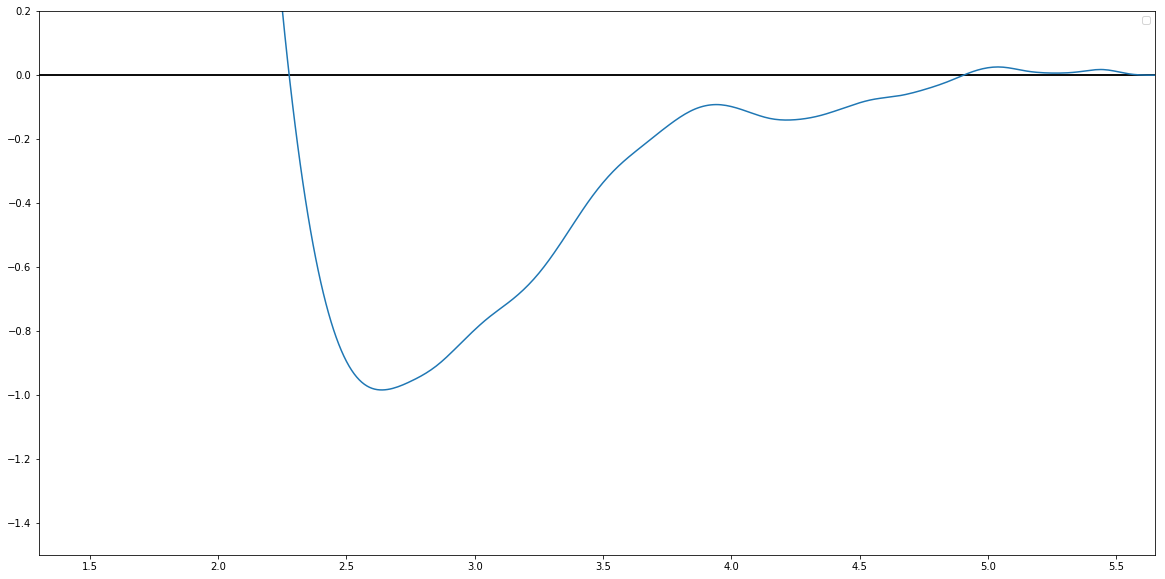

In [969]:
plt.figure(figsize=(20,10))
# plt.plot(np.array(b_weight9[2:])*(6*0.1**3) , 'g')
# plt.plot(np.array(b_weight8[2:])*(6*0.1**3) , 'b')
# plt.plot(np.array(b_weight7[2:])*(6*0.1**3) , 'm')
plt.plot(np.array(b_all[2:])*(6*0.1**3) , 'y')
plt.ylim(-1.2,1)
plt.hlines(0, 0, 42)
plt.legend()


rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[2:], p_knot, r) for r in rr])
plt.xlim(1.3,)
plt.ylim(-1.5,0.2)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])

In [970]:
bounds

[[0, 146],
 [146, 147],
 [147, 383],
 [383, 389],
 [389, 588],
 [588, 788],
 [788, 793],
 [793, 915],
 [915, 1041],
 [1041, 1174],
 [1174, 1265],
 [1265, 1401],
 [1401, 1413]]

[-1139.007, 0.0, -1136.632, -1136.318, -1190.544, -1127.606]
[-1139.2, -0.0, -1136.401, -1136.751, -1190.261, -1127.175]


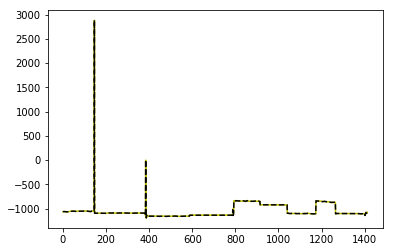

In [971]:
plt.plot(X.dot(b_all), 'y')
#plt.plot(X.dot(b_weight4), 'm')
plt.plot(y, 'k--')
# plt.xlim(len(X)-7,len(X)-1)
# plt.ylim(-1200,-1120)

#print(list(y[382:389]), list(X.dot(b_0)[382:389]))
# print([round(z, 3) for z in X.dot(b_weight9)[-6:]])
# print([round(z, 3) for z in X.dot(b_weight8)[-6:]])
# print([round(z, 3) for z in X.dot(b_weight7)[-6:]])


#print(bounds[index][0])
#print([round(z, 3) for z in X.dot(b_all)[-6:]])
print([round(z, 3) for z in X.dot(b_all)[bounds[3][0]:bounds[3][1]]])
print([round(z, 3) for z in y[bounds[3][0]:bounds[3][1]]])

#print([round(z, 3) for z in y[-6:]])

In [112]:
for key in targets.keys():
    targets[key]['weight'] = 1.0

In [113]:
for i, stat in enumerate(stats_list[-1:]):
    Xallx, yallx, weights, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)

ValueError: could not broadcast input array from shape (430,43) into shape (135,43)

In [114]:
energy(Xallx, b_all[1:])

array([-1133.70693835, -1133.68332447, -1133.64029846, ...,
       -1136.31773069, -1190.54413947, -1127.60588242])

In [111]:
sys.getsizeof(Xallx[1])/sys.getsizeof(Xallx[0]), sys.getsizeof(b_all)

(134, 800)

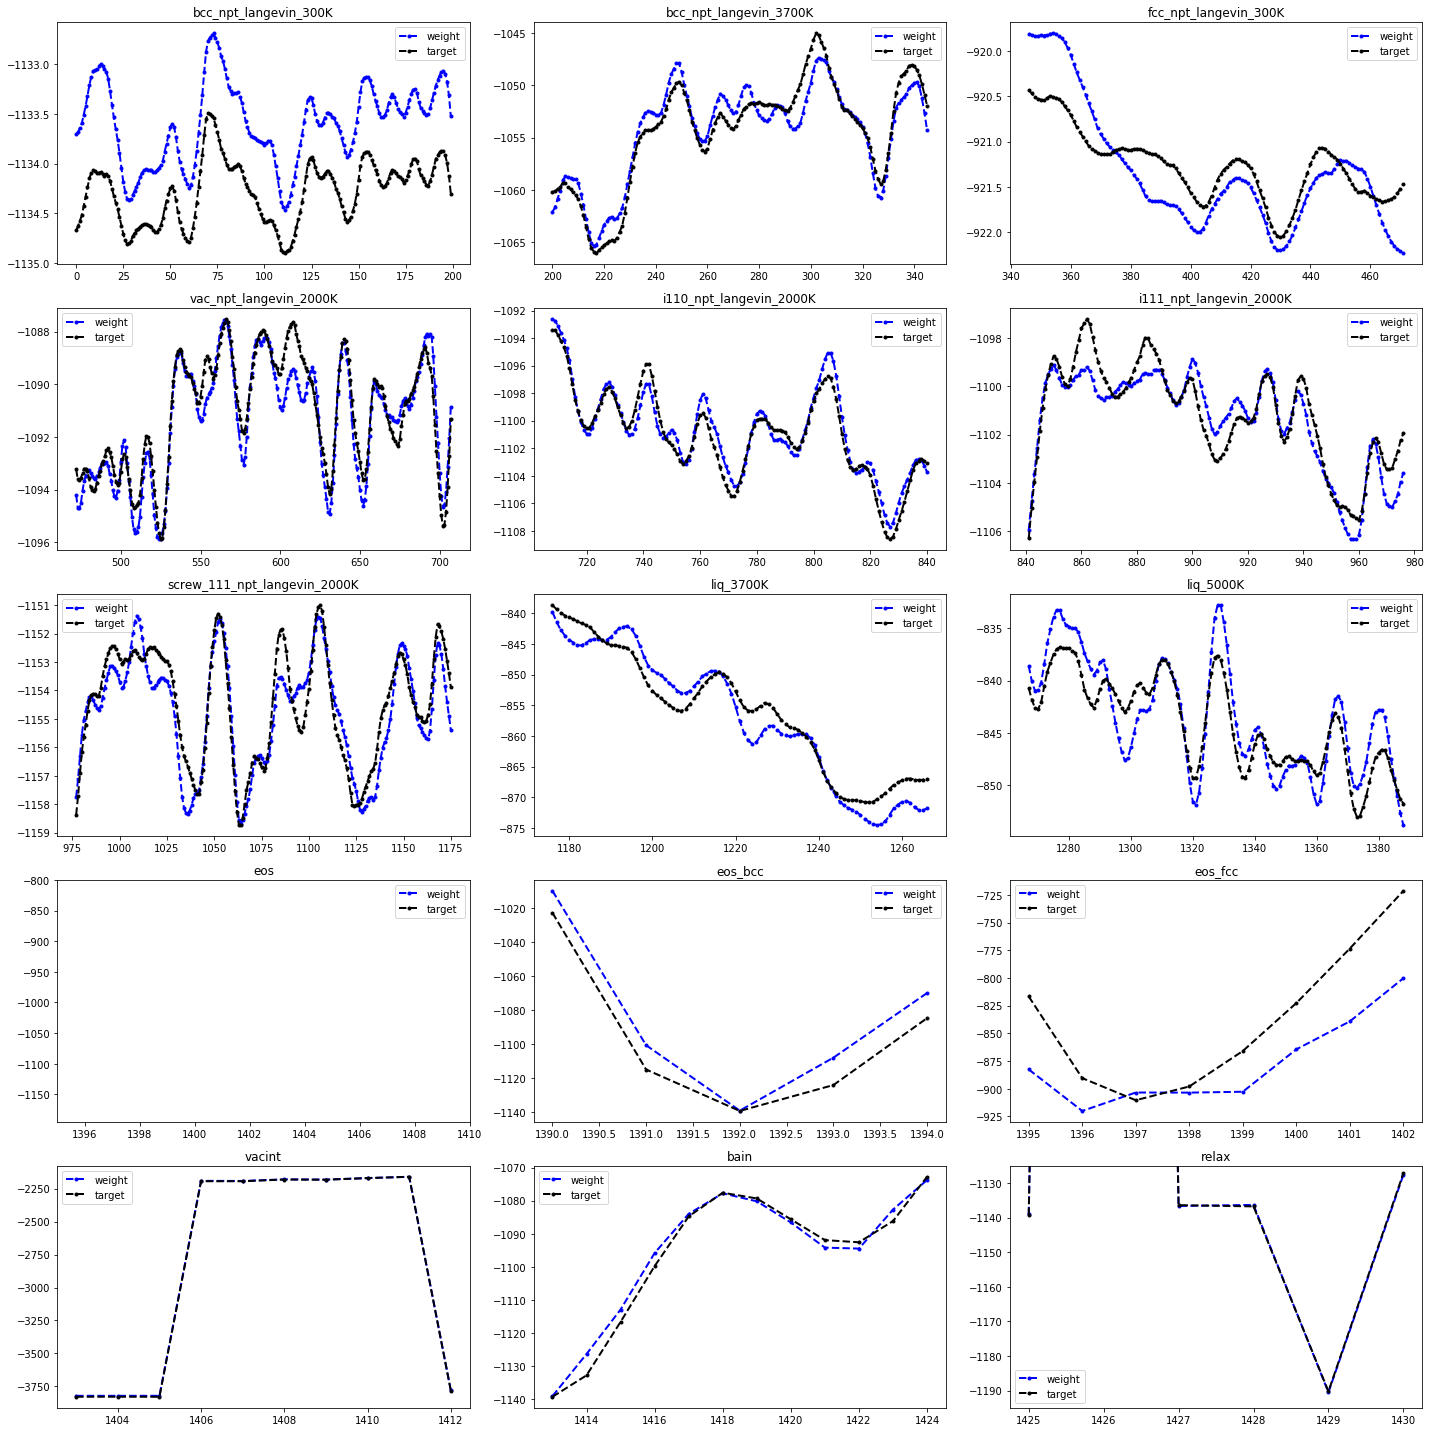

In [974]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
#    axes[i,j].plot(X.dot(b_lamb), 'b--', lw=2, label='sd/lambda')
#    axes[i,j].plot(X.dot(b_ext), 'g--', lw=2, label='x')
    rr = list(range(bounds[k][0], bounds[k][1]))

#     axes[i,j].plot(rr, Xall.dot(b_weight11)[bounds[k][0]:bounds[k][1]], 'r.--', lw=2, label='weight')
    axes[i,j].plot(rr, Xallx.dot(b_all)[bounds[k][0]:bounds[k][1]], 'b.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight8)[bounds[k][0]:bounds[k][1]], 'g.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight9)[bounds[k][0]:bounds[k][1]], 'm.--', lw=2, label='weight')
    #axes[i,j].plot(rr, Xall.dot(b_init)[bounds[k][0]:bounds[k][1]], 'y.--', lw=2, label='weight')

    axes[i,j].plot(rr, yallx[bounds[k][0]:bounds[k][1]], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
    if trj == 'eos':
        axes[i,j].set_ylim(-1195, -800)
        axes[i,j].set_xlim(1395,1410)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [816]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi)

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi)

len 50


In [817]:
len(stats_tpf['relax']['energy'][0][2]), len(stats_bspline['relax']['energy'][0][2])

(50, 46)

In [818]:
for key in targets.keys():
    targets[key]['weight'] = 1.0

In [819]:
mb_knots = list(np.linspace(3.75, 5.25, 16))
pair_knots = list(np.linspace(1.05, 5.25, 43))
#pair_knots = list(np.linspace(2.05, 5.25, 33))

print(mb_knots)
print(pair_knots)

# Select knots for optimization
# cycle over knots of selected models
stats_list = []
for knot in mb_knots:
    edens_knots = [knot]
    stats = downselect(stats_bspline, pair_knots, edens_knots)
    stats_list.append(stats)

[3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65, 4.75, 4.85, 4.95, 5.05, 5.15, 5.25]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05, 5.15, 5.25]


In [820]:
for i, stat in enumerate(stats_list[-1:]):
    Xall, yall, weights, beta, bounds = make_sd_matrices(targets, stat, keytrj=tkeys)

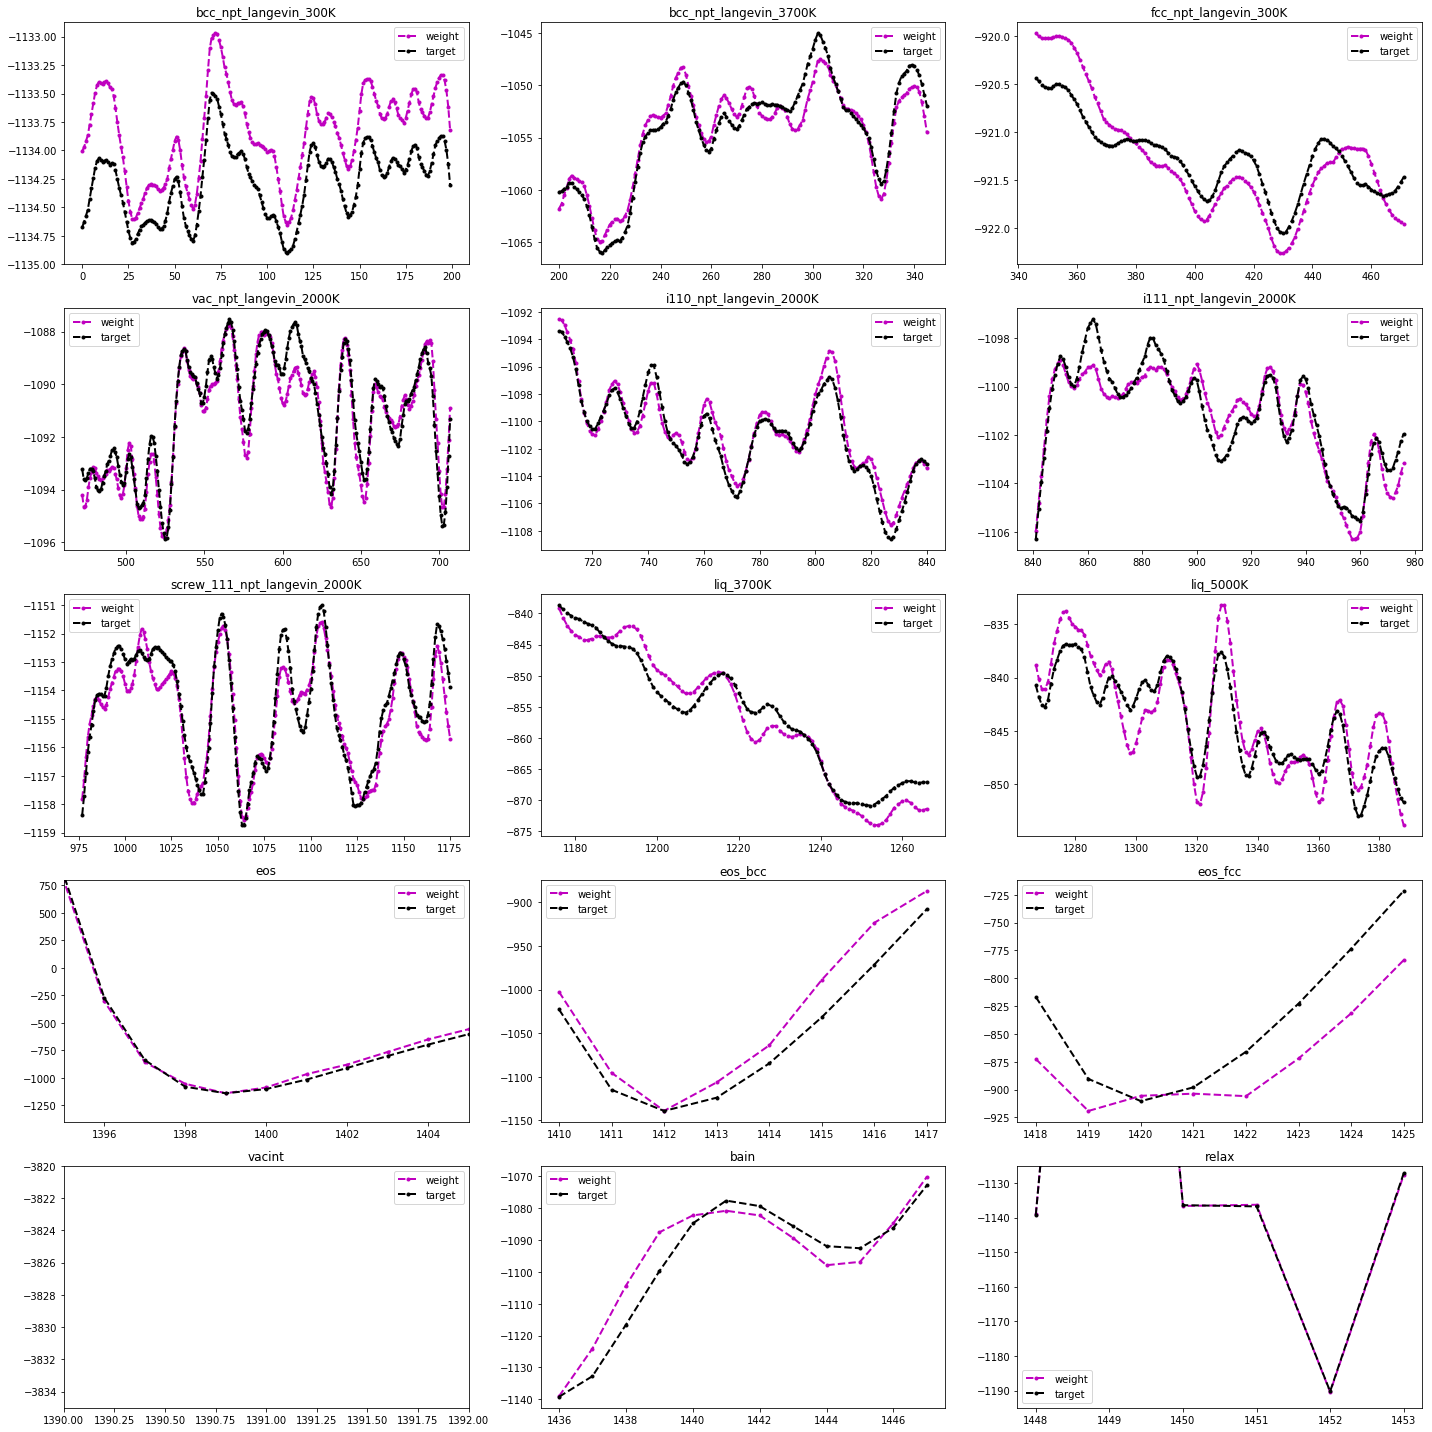

In [822]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
#    axes[i,j].plot(X.dot(b_lamb), 'b--', lw=2, label='sd/lambda')
#    axes[i,j].plot(X.dot(b_ext), 'g--', lw=2, label='x')
    rr = list(range(bounds[k][0], bounds[k][1]))

#     axes[i,j].plot(rr, Xall.dot(b_weight11)[bounds[k][0]:bounds[k][1]], 'r.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight7)[bounds[k][0]:bounds[k][1]], 'b.--', lw=2, label='weight')
#     axes[i,j].plot(rr, Xallx.dot(b_weight8)[bounds[k][0]:bounds[k][1]], 'g.--', lw=2, label='weight')
    axes[i,j].plot(rr, Xall.dot(b_all)[bounds[k][0]:bounds[k][1]], 'm.--', lw=2, label='weight')
    #axes[i,j].plot(rr, Xall.dot(b_init)[bounds[k][0]:bounds[k][1]], 'y.--', lw=2, label='weight')

    axes[i,j].plot(rr, yall[bounds[k][0]:bounds[k][1]], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
        
    if trj == 'vacint':
        axes[i,j].set_ylim(-3835, -3820)
        axes[i,j].set_xlim(1390,1392)
        
    if trj == 'eos':
        axes[i,j].set_ylim(-1400, 800)
        axes[i,j].set_xlim(1395,1405)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [504]:
p_knots = np.array(pair_knots)+0.4
p_knots

array([1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15, 2.25, 2.35, 2.45,
       2.55, 2.65, 2.75, 2.85, 2.95, 3.05, 3.15, 3.25, 3.35, 3.45, 3.55,
       3.65, 3.75, 3.85, 3.95, 4.05, 4.15, 4.25, 4.35, 4.45, 4.55, 4.65,
       4.75, 4.85, 4.95, 5.05, 5.15, 5.25, 5.35, 5.45, 5.55, 5.65])

In [505]:
def _bspline_coeffs_to_tpf(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = 4
    P = np.zeros((n_tot+4, n_tot), dtype=float)
    for i in range(n_tot+4):
        #ii = i - 4
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot-1:
                continue
            P[i, i+j-o] = p

    return P

In [506]:
M = _bspline_coeffs_to_tpf(43)

In [507]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
b11_ext = np.array(list(b_all[2:]))#*(6*0.1**3)
print(b11_ext)
tpf_coeff = M.dot(b11_ext)
print(tpf_coeff)

[ 4.22824426e+03  3.54009480e+03  2.91119261e+03  2.34153772e+03
  1.83113026e+03  1.37997039e+03  9.88058321e+02  6.55394274e+02
  3.81978459e+02  1.67811053e+02  1.24862009e+01 -8.79627304e+01
 -1.43545176e+02 -1.67016514e+02 -1.68316234e+02 -1.58859588e+02
 -1.52245978e+02 -1.41522891e+02 -1.31799084e+02 -1.24427156e+02
 -1.07866113e+02 -8.29740112e+01 -6.06836589e+01 -4.81849563e+01
 -4.36744378e+01 -3.91472388e+01 -3.22134949e+01 -2.58537638e+01
 -2.26912671e+01 -2.12961404e+01 -2.06873517e+01 -1.86526528e+01
 -1.45559864e+01 -1.10689543e+01 -8.78888460e+00 -5.32464713e+00
 -1.32322585e+00  9.00599115e-01  1.19455876e+00  1.38108240e+00
 -4.40635093e-01 -1.37195754e+00 -1.22719835e+00]
[ 4.22824426e+03 -1.33728823e+04  1.41202790e+04 -4.97564098e+03
  9.10758972e-05  5.38825989e-05  3.86238098e-05  5.24520874e-06
 -2.62260437e-06 -3.64780426e-05 -4.06030059e-01 -3.56078100e+00
 -6.04279995e+00 -2.74594337e+00  2.81588787e+00 -1.47576168e+00
 -2.18415010e+00  2.05519152e+01 -1.2061

In [508]:
p_knot = [1.05, 1.15, 1.25, 1.35] + list(p_knots)
len(tpf_coeff), len(p_knot)

(47, 47)

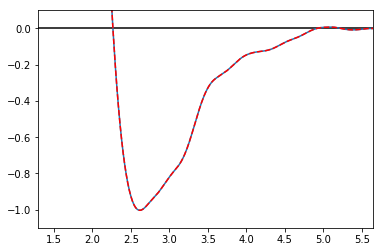

In [517]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[2:], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[2:], p_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, tpf_coeff, p_knot) for r in rr], 'r--')
plt.ylim(-1.1,0.1)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

In [513]:
tpf_coeff

array([ 4.22824426e+03, -1.33728823e+04,  1.41202790e+04, -4.97564098e+03,
        9.10758972e-05,  5.38825989e-05,  3.86238098e-05,  5.24520874e-06,
       -2.62260437e-06, -3.64780426e-05, -4.06030059e-01, -3.56078100e+00,
       -6.04279995e+00, -2.74594337e+00,  2.81588787e+00, -1.47576168e+00,
       -2.18415010e+00,  2.05519152e+01, -1.20612704e+01,  3.75615722e+00,
        1.28935941e+01, -1.23990495e+01, -1.00747538e+01,  3.74290898e+00,
        8.99336571e+00,  6.20139912e+00, -5.61500046e+00, -5.37042186e+00,
        3.57335970e-01,  4.05308592e+00, -4.48832229e-01,  1.23121627e+00,
       -1.57619130e+00, -3.30765875e+00,  2.07427372e+00,  2.98845802e+00,
       -3.03811395e+00, -1.66779622e+00,  2.16251113e+00,  1.97469831e+00,
       -3.72323444e+00,  4.79944132e+00, -2.71294960e+00, -1.79329082e-01,
       -2.31599501e+00,  3.53683585e+00, -1.22719835e+00])

In [516]:
print('pair')

for c, k in zip(tpf_coeff, p_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))

print('edens') 
for c, k in zip([1.0], [5.25]):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
        
print('embed')
#print(-4.42166597e-01,  1.12818607e-04)
print(-4.49779872e-01,  1.09664665e-04)

pair
+4228.2442627d0*(1.05d0 - r)**3*H(1.05d0 - r)
-13372.8822546d0*(1.15d0 - r)**3*H(1.15d0 - r)
+14120.2789984d0*(1.25d0 - r)**3*H(1.25d0 - r)
-4975.64097977d0*(1.35d0 - r)**3*H(1.35d0 - r)
+9.10758972168e-05d0*(1.45d0 - r)**3*H(1.45d0 - r)
+5.3882598877e-05d0*(1.55d0 - r)**3*H(1.55d0 - r)
+3.86238098145e-05d0*(1.65d0 - r)**3*H(1.65d0 - r)
+5.24520874023e-06d0*(1.75d0 - r)**3*H(1.75d0 - r)
-2.62260437012e-06d0*(1.85d0 - r)**3*H(1.85d0 - r)
-3.64780426025e-05d0*(1.95d0 - r)**3*H(1.95d0 - r)
-0.406030058861d0*(2.05d0 - r)**3*H(2.05d0 - r)
-3.56078100204d0*(2.15d0 - r)**3*H(2.15d0 - r)
-6.04279994965d0*(2.25d0 - r)**3*H(2.25d0 - r)
-2.74594336748d0*(2.35d0 - r)**3*H(2.35d0 - r)
+2.8158878684d0*(2.45d0 - r)**3*H(2.45d0 - r)
-1.4757616818d0*(2.55d0 - r)**3*H(2.55d0 - r)
-2.18415009975d0*(2.65d0 - r)**3*H(2.65d0 - r)
+20.5519151688d0*(2.75d0 - r)**3*H(2.75d0 - r)
-12.061270386d0*(2.85d0 - r)**3*H(2.85d0 - r)
+3.75615721941d0*(2.95d0 - r)**3*H(2.95d0 - r)
+12.893594116d0*(3.05d0 - r)**3*H(3

In [ ]:
par = param_list[2]
print('pair')
for c, k in zip(par['params']['pair'], par['hyperparams']['pair']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('edens')   
for c, k in zip(par['params']['edens'], par['hyperparams']['edens']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('embed')    
par['params']['embed']

Parameters given to Yuri:

Embedding:
-4.42166597e-01,  1.12818607e-04,
Pair potential coefficients: Knots ending at 5.65 with steps of 0.1 A:

4.51698420e+03,  3.75910139e+03, 3.06924350e+03,  2.44738802e+03,  1.89346739e+03,  1.40738478e+03,
9.89029865e+02,  6.38294633e+02,  3.55089127e+02,  1.39357269e+02,
       -9.60824592e+00, -9.86104306e+01, -1.44135463e+02, -1.65813774e+02,
       -1.73239670e+02, -1.65893890e+02, -1.60198554e+02, -1.46418160e+02,
       -1.35762684e+02, -1.25923736e+02, -1.10532902e+02, -8.90260796e+01,
       -6.86880677e+01, -5.45283774e+01, -4.52604866e+01, -3.77851927e+01,
       -3.19692325e+01, -2.76892221e+01, -2.45864649e+01, -2.09702658e+01,
       -1.96949536e+01, -2.16298673e+01, -1.49970585e+01, -9.26360379e+00,
       -1.22233430e+01, -5.85168131e+00,  1.60207091e+00,  3.86904582e+00,
       -2.36332511e+00,  2.69685169e+00, -1.92552950e+00, -5.24093457e-01,
        1.38798423e-01